In [1]:
import os

from omegaconf import DictConfig, OmegaConf
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

from coco_mapping.squidle_data import SquidleData
from coco_mapping.squidle_connection import SquidleAnnotator, SquidleConnection
from sqapi.api import SQAPI


# 0. Setup config

In [37]:
### Config and squidle access setup
config = "squidle_hand_target.yaml"
config = "squidle_redcup_default.yaml"
abs_config_dir=os.path.abspath("../config/dataset")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    opt = compose(config_name=config)
    #print(OmegaConf.to_yaml(opt, resolve=True))
#print(opt)
OmegaConf.set_struct(opt, False)

dataset = SquidleData(opt)
sq_annotator = SquidleAnnotator(api_key=opt.annotate_api_token, host=opt.url)
sq_annotator = SquidleAnnotator(api_key=opt.api_token, host=opt.url)
squidle_connection = SquidleConnection(sqapi=sq_annotator.sqapi)

/home/heather/.conda/envs/py310_torch/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'squidle_redcup_default.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


# 1. Get annotations


Red Cup sponge not in [5862, 5863, 12745, 12750, 12747, 12739]

Counter({13249: 919, 5861: 121, 12749: 116, 12748: 109, 12737: 100, 12751: 99, 10567: 36, 10566: 26, 7933: 24, 12339: 23, 10570: 19, 7914: 18, 7925: 18, 5853: 16, 466: 14, 12740: 14, 5852: 13, 7927: 12, 8126: 12, 7932: 11, 11625: 10, 12444: 10, 11637: 9, 7987: 8, 4003: 7, 7978: 7, 10546: 6, 10862: 6, 10880: 6, 11609: 6, 7940: 5, 8048: 5, 7931: 4, 8127: 4, 9472: 4, 10547: 4, 3418: 3, 5869: 3, 7939: 3, 7984: 3, 10870: 3, 3988: 2, 7770: 2, 10885: 2, 11186: 2, 442: 1, 2133: 1, 7929: 1, 7937: 1, 7938: 1, 7941: 1, 7942: 1, 8100: 1, 8123: 1, 10548: 1, 10553: 1})
Counter({7111: 1238, 13288: 540, 7104: 77})

In [3]:
label_ids = list(dataset.opt.squidle_mapping)
annotation_set_ids = list(dataset.opt.annotation_set_ids) if dataset.opt.annotation_set_ids is not None else []
exclude_annotation_set_ids = dataset.opt.exclude_annotation_set_ids if dataset.opt.exclude_annotation_set_ids is not None else []


https://squidle.org/api/annotation?q={"filters":[{"name":"label","op":"has","val":{"name":"id","op":"in","val":[13288]}},{"name":"annotation_set_id","op":"in","val":[13250,13251]},{"name":"needs_review","op":"eq","val":"False"},{"name":"annotation_set","op":"has","val":{"name":"is_child","op":"eq","val":false}},{"name":"point","op":"has","val":{"name":"has_xy","op":"eq","val":true}}]}&page=1&results_per_page=1000

In [6]:
include_annotation_sets = False # if false it doesnt' specify annotation set_ids to include
exclude_annotation_sets = list(set(dataset.opt.needs_review_annotation_set_ids) |
                                                                          set(exclude_annotation_set_ids))
exclude_annotation_sets = [s for s in exclude_annotation_sets if s is not None]
annotation_list = dataset.squidle_connection.get_all_annotations_from_set(annotation_set_ids, label_ids=label_ids,
                                                              include_annotation_sets=include_annotation_sets,
                                                              exclude_annotation_sets=exclude_annotation_sets,
                                                              results_per_page=1000)

HTTP-GET: https://squidle.org/api/annotation?q={"filters":[{"name":"label","op":"has","val":{"name":"id","op":"in","val":[7158]}},{"name":"annotation_set_id","op":"not_in","val":[13249,13250,13251,17366]},{"name":"needs_review","op":"eq","val":"False"},{"name":"annotation_set","op":"has","val":{"name":"is_child","op":"eq","val":false}},{"name":"point","op":"has","val":{"name":"has_xy","op":"eq","val":true}}]}&page=1&results_per_page=1000 ... ✅ | 200 | Done in 7.81 s
Extracting 2 pages with 1407 records.
HTTP-GET: https://squidle.org/api/annotation?q={"filters":[{"name":"label","op":"has","val":{"name":"id","op":"in","val":[7158]}},{"name":"annotation_set_id","op":"not_in","val":[13249,13250,13251,17366]},{"name":"needs_review","op":"eq","val":"False"},{"name":"annotation_set","op":"has","val":{"name":"is_child","op":"eq","val":false}},{"name":"point","op":"has","val":{"name":"has_xy","op":"eq","val":true}}]}&page=2&results_per_page=1000 ... ✅ | 200 | Done in 4.77 s
HTTP-GET: https://sq

In [ ]:
# Run this if you're excluding annotation sets that have annotations that need review.
annotation_list +=  dataset.squidle_connection.get_all_annotations_from_set(list(dataset.opt.needs_review_annotation_set_ids),
                                                                       label_ids=label_ids,
                                                                       include_annotation_sets=True,
                                                                       needs_review=True,
                                                                       results_per_page=200)

##### Ensure the training data (semi/excluding test/val annotation_sets) does not have any media from them.
  - 10820 # 4 handfish
  - 10827 # 4 handfish
  - 10829 # 6 handfish
  - 10818 # 1 handfish
  - 10819 # 1 handfish


##### Create a list of media_collections and media_id to exclude because they are used by the excluded annotation sets.

In [8]:
excluded_media_collection_ids = []
excluded_media = []
annotation_set_ids = list(set([a['annotation_set_id'] for a in annotation_list]))
print(sorted(annotation_set_ids))

[442, 3418, 3420, 4003, 4004, 5852, 5853, 7914, 7918, 7919, 7925, 7927, 7931, 7932, 7933, 7937, 7938, 7940, 7941, 7942, 7943, 7944, 7950, 7953, 7956, 7964, 7971, 7978, 7984, 7987, 8048, 8066, 8100, 8123, 8126, 8127, 8178, 9482, 10545, 10546, 10548, 10566, 10567, 10570, 10636, 12339, 12444, 13087, 13200, 13201, 13202, 13203, 13298, 13344, 13376, 13397, 13538, 15810]


In [9]:
#media_id_dict = {}
for asi in exclude_annotation_set_ids:
    media_collection_id = dataset.squidle_connection.sqapi.get(f"/api/annotation_set/{asi}").execute().json()
    media_collection_id = media_collection_id['media_collection']['id']
    excluded_media_collection_ids.append(media_collection_id)
    page = 1
    request = sq_annotator.sqapi.get("/api/media",
                                     page=page, results_per_page=1000)
    request.filter(name="media_collection_media", op="any",
                   val={'name': "media_collection_id", 'op': 'eq', 'val': media_collection_id})
    result = request.execute().json()
    #for m in result['objects']:
    #    media_id_dict[m['id']] = m
    excluded_media += [m['id'] for m in result['objects']]
    print(f"Total pages {result['total_pages']}")
    while page < result['total_pages']:
        page += 1
        request = sq_annotator.sqapi.get("/api/media",
                                         page=page, results_per_page=1000)
        request.filter(name="media_collection_media", op="any",
                       val={'name': "media_collection_id", 'op': 'eq', 'val': media_collection_id})
        result = request.execute().json()
        #for m in result['objects']:
        #    media_id_dict[m['id']] = m        
        excluded_media += [m['id'] for m in result['objects']]        

HTTP-GET: https://squidle.org/api/annotation_set/13250 ... ✅ | 200 | Done in 0.95 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"media_collection_media","op":"any","val":{"name":"media_collection_id","op":"eq","val":11601}}]}&page=1&results_per_page=1000 ... ✅ | 200 | Done in 0.18 s
Total pages 1
HTTP-GET: https://squidle.org/api/annotation_set/13251 ... ✅ | 200 | Done in 0.85 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"media_collection_media","op":"any","val":{"name":"media_collection_id","op":"eq","val":11602}}]}&page=1&results_per_page=1000 ... ✅ | 200 | Done in 0.16 s
Total pages 1
HTTP-GET: https://squidle.org/api/annotation_set/13249 ... ✅ | 200 | Done in 2.62 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"media_collection_media","op":"any","val":{"name":"media_collection_id","op":"eq","val":11600}}]}&page=1&results_per_page=1000 ... ✅ | 200 | Done in 0.74 s
Total pages 1
HTTP-GET: https://squidle.org/api/annotation_set/173

##### To Create Media Collection: Get media ids for annotations retrieved.  Put them in a dictionary.

In [19]:
# Get media_items for annotation_list
media_ids = list(set([a['point']['media_id'] for a in annotation_list]))
media_id_dict = {}
for m_id in media_ids:
    request = sq_annotator.sqapi.get("/api/media",
                                     page=page, results_per_page=500)
    request.filter(name="id", op="eq",
                   val=m_id)
    result = request.execute().json()
    for m in result['objects']:
        media_id_dict[m['id']] = m
        


HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"id","op":"eq","val":7129088}]}&page=4&results_per_page=500 ... ✅ | 200 | Done in 0.11 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"id","op":"eq","val":3252224}]}&page=4&results_per_page=500 ... ✅ | 200 | Done in 0.10 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"id","op":"eq","val":7184389}]}&page=4&results_per_page=500 ... ✅ | 200 | Done in 0.09 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"id","op":"eq","val":6961159}]}&page=4&results_per_page=500 ... ✅ | 200 | Done in 0.09 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"id","op":"eq","val":6893581}]}&page=4&results_per_page=500 ... ✅ | 200 | Done in 0.09 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"id","op":"eq","val":7716877}]}&page=4&results_per_page=500 ... ✅ | 200 | Done in 0.10 s
HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"id","op":"eq","val":8347669}]}&

In [11]:
from collections import defaultdict
annotation_media_id_dict = defaultdict(list)
multi_ann_media = 0
freq= []
for a in annotation_list:
    media_id = a['point']['media_id']
    annotation_media_id_dict[media_id].append(a)
for k, v in annotation_media_id_dict.items():
    freq.append(len(v))
    if len(v) > 1:
        #print(media_id)
        multi_ann_media +=1
print(multi_ann_media)

323


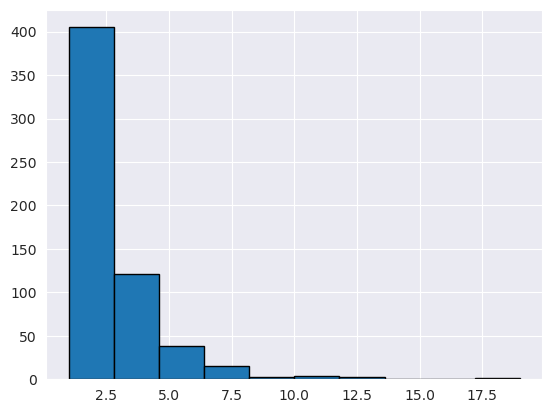

In [12]:
import matplotlib.pyplot as plt
plt.hist(freq, bins=10, edgecolor='black')
plt.show()

In [13]:
from collections import Counter
deployment_counter = []
for a_media_id in annotation_media_id_dict.keys():
    d_id = media_id_dict[a_media_id]['deployment_id']
    d_key = media_id_dict[a_media_id]['deployment']['key']
    deployment_counter.append(f"{d_id}_{d_key}")

deployment_counter = Counter(deployment_counter)
for d in sorted(deployment_counter):
    print(d, deployment_counter[d])


10776_r20200117_023640_trump_north 3
10777_r20200117_051311_trump_center 1
10940_r20200630_040959_NG03_Pinnacles_1 2
10941_r20200630_051416_NG04_Pinnacles_2 2
10952_r20200818_220209_NG21_Pinnacles_3 1
11668_r20210614_000137_SS04_TF_NPZ_07 11
11669_r20210614_034824_SS05_TF_NPZ_01 32
11670_r20210614_062740_SS06_TF_NPZ_02 21
11671_r20210614_222648_SS07_TF_NPZ_06 6
11673_r20210615_024126_SS09_TF_NPZ_03 13
11674_r20210615_054656_SS10_TF_NPZ_08 1
11675_r20210615_222253_SS11_TF_Ref_N_1 12
11676_r20210616_004810_SS12_TF_Ref_N_1_second_half 4
11679_r20210616_215942_SS15_TF_Ref_C_1 9
11680_r20210616_234712_SS16_TF_Ref_C_1_second_half 9
11681_r20210617_010409_SS17_TF_Ref_C_1_third 13
11682_r20210617_033152_SS18_TF_NPZ_04_reversed 1
11683_r20210617_050102_SS19_TF_NPZ_04_reversed_second_half 7
11684_r20210422_021429_NG08_trumpeter_north 18
11685_r20210422_053707_NG10_trumpeter_centre 6
11689_r20210424_060908_NG20_tasmania_storm_bay_SB_14_north 21
11691_r20210425_011934_NG23_Trumpeter_bay_broad_sout

LOCKED Test15 - 42 images from deployment 11682 and ahead (ie r20210617_033152_SS18_TF_NPZ_04_reversed 2)
train85 - everything before 20210617 - 242 annotations



In [ ]:


train, test = [], []
for a in annotation_list_orig:
    media_id = a['point']['media_id']
    if media_id_dict[media_id]['deployment_id'] >= 11676:
        test.append(a)
    else:
        train.append(a)
        


##### Remove annotations from media that is excluded (ie in excluded annotation_set_ids)

In [14]:
clean_annotation_list = []
for a in annotation_list:
    media_id = a['point']['media_id']
    if media_id not in excluded_media:
        clean_annotation_list.append(a)
    #else:
    #    print(f"Removing {media_id}")
print(f"Original annotations {len(annotation_list)}, cleaned annotations {len(clean_annotation_list)}")
annotation_list = clean_annotation_list
       

Original annotations 1407, cleaned annotations 986


In [46]:
[a for a in annotation_list if a['point']['media_id']==554162 ]

[]

In [48]:
##### Remove duplicate point annotation
auv_annotations = [a for a in annotation_list if '_NG' in media_id_dict[a['point']['media_id']]['deployment']['key'] or '_SS' in media_id_dict[a['point']['media_id']]['deployment']['key']]
annotation_list = auv_annotations
print(f"Original annotations {len(annotation_list)} AUV annotations {len(auv_annotations)}")

Original annotations 795 AUV annotations 795


In [15]:
from collections import defaultdict
annotations_by_media_id = defaultdict(list)
for a in annotation_list:
    p = a['point']
    annotations_by_media_id[(p['media_id'], int(p['x']*100), int(p['y']*100))].append(a)
    
dedup_list = []
multi_anns = {}
dedup_anns = {}
for k, v in annotations_by_media_id.items():
    dedup_list.append(v[0])
    if len(v) > 1:
        multi_anns[k] = v
    else:
        dedup_anns[k] = v
print(f"Original annotations: {len(annotation_list)}, Deduplicated points {len(dedup_list)}")
annotation_list = dedup_list

Original annotations: 986, Deduplicated points 980


# 2. Create media_collection and annotation_set

##### Creating random selsections of training data
Create 4 * 50 random selections plus 1 X 41 images for validation

In [16]:
import random

def findElements(lst1, lst2):
    return list(np.array(lst1)[lst2])
selection = [i for i in range(len(train))]
random.shuffle(selection)

NameError: name 'train' is not defined

In [ ]:
val = selection[0:41]
train_1 = selection[41:91]
train_2 = selection[91:141]
train_3 = selection[141:191]
train_4 = selection[191:241]

In [ ]:
set(val).intersection(set(train_3))

In [ ]:
#original_query_annotation_list = annotation_list
annotation_list = findElements(train, train_4)

In [49]:
from datetime import datetime

sorted_annotations = sorted(annotation_list, key=lambda x: datetime.fromisoformat(media_id_dict[x['point']['media_id']]['created_at']))

print([media_id_dict[x['point']['media_id']]['created_at'] for x in sorted_annotations])

['2021-01-18T03:21:16.026750', '2021-01-18T03:21:17.886454', '2021-01-18T03:22:43.208230', '2021-01-18T03:22:43.226504', '2021-01-18T03:42:37.028208', '2021-10-25T05:16:46.331482', '2021-10-25T05:16:46.697969', '2021-10-25T05:16:46.697969', '2021-10-25T05:16:47.496053', '2021-10-25T05:16:47.496053', '2021-10-25T05:16:48.150189', '2021-10-25T05:16:48.150189', '2021-10-25T05:16:48.150189', '2021-10-25T05:16:48.150189', '2021-10-25T05:16:48.150189', '2021-10-25T05:16:48.256718', '2021-10-25T05:16:48.303926', '2021-10-25T05:16:48.363119', '2021-10-25T05:16:48.363119', '2021-10-25T05:16:48.669973', '2021-10-25T05:16:48.823431', '2021-10-25T05:16:48.823431', '2021-10-25T05:16:49.521426', '2021-10-25T05:16:49.794011', '2021-10-25T05:16:49.794011', '2021-10-25T05:19:53.329495', '2021-10-25T05:19:53.358493', '2021-10-25T05:19:53.427982', '2021-10-25T05:19:53.427982', '2021-10-25T05:19:53.427982', '2021-10-25T05:19:53.427982', '2021-10-25T05:19:53.427982', '2021-10-25T05:19:53.427982', '2021-10-

##### Create media collection based on annotation_list

In [ ]:
description = f"Media and annotations for deployments including and before 11671_r20210614_222648_SS07_TF_NPZ_06 6  from annotation sets {set([a['annotation_set_id'] for a in annotation_list])}"
description = "Media and annotations for all unique handfish detections by either human or AI."
#description = f"Random selection of n=50 handfish annotations v4 from Train 85pc dataset (13373) for training"
name = "Handfish Detections - Human and AI generated"
group_id = 137 # ACFR Marine

In [60]:
description = f"Point annotations of Gorgonian Red Pteronisis Like fan octocorals from all annotations excluding annotation sets {exclude_annotation_set_ids}. First 600 of 795 annotations based on created_at date on media."
name = 'Gorgonian Red - all annotations - training'

In [61]:
media_collection_id = sq_annotator.create_media_collection(name=name, description=description)
print(media_collection_id)

HTTP-POST: https://squidle.org/api/media_collection ... ✅ | 201 | Done in 0.24 s
14181


##### Add media to collection

In [62]:
# ADDING MEDIA to collection
media_ids = list(set([a['point']['media_id'] for a in sorted_annotations[:600]]))
sq_annotator.add_media_to_collection(media_collection_id, media_ids)
print("Finished!!!")

HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"media_collection_media","op":"any","val":{"name":"media_collection_id","op":"eq","val":14181}}]}&page=1&results_per_page=1000 ... ✅ | 200 | Done in 0.12 s
HTTP-POST: https://squidle.org/api/media_collection/14181/media/6884864 ... ✅ | 200 | Done in 0.12 s
HTTP-POST: https://squidle.org/api/media_collection/14181/media/6931968 ... ✅ | 200 | Done in 0.11 s
HTTP-POST: https://squidle.org/api/media_collection/14181/media/7129088 ... ✅ | 200 | Done in 0.10 s
HTTP-POST: https://squidle.org/api/media_collection/14181/media/6932996 ... ✅ | 200 | Done in 0.11 s
HTTP-POST: https://squidle.org/api/media_collection/14181/media/6961159 ... ✅ | 200 | Done in 0.12 s
HTTP-POST: https://squidle.org/api/media_collection/14181/media/7121415 ... ✅ | 200 | Done in 0.15 s
HTTP-POST: https://squidle.org/api/media_collection/14181/media/7170569 ... ✅ | 200 | Done in 0.11 s
HTTP-POST: https://squidle.org/api/media_collection/14181/media/7172618 ...

In [27]:
print(set(media_ids).intersection(set(excluded_media)))

set()


##### Create annotation set

In [ ]:
#media_collection_id = 11592 #Handfish Train Dataset
media_collection_id = 14168

* New annotation set (like other annotation sets?)
* Add annotations

In [28]:
# Get label_scheme_id
group_id = 358
label_scheme_id = 7
label_scheme_ids = list(set([a['label']['label_scheme_id'] for a in annotation_list]))
print(label_scheme_ids)

[7]


In [63]:
annotation_set_id = sq_annotator.create_annotation_set(name, description, media_collection_id, label_scheme_id, group_id=group_id)
print(annotation_set_id)

HTTP-POST: https://squidle.org/api/annotation_set ... ✅ | 201 | Done in 0.92 s
HTTP-POST: https://squidle.org/api/annotation_set/17379/group/358 ... ✅ | 200 | Done in 0.09 s
17379


# 3. Add annotations


In [64]:
# Use this if you're not creating a new media_collection and annotation set
#annotation_set_id = annotation_list[0]['annotation_set_id']
annotation_set_details = dataset.squidle_connection.sqapi.get(f"/api/annotation_set/{annotation_set_id}").execute().json()
#media_collection_id = media_collection_id['media_collection']['id']

print(annotation_set_details)

HTTP-GET: https://squidle.org/api/annotation_set/17379 ... ✅ | 200 | Done in 0.89 s
{'annotation_count': 0, 'children': [], 'created_at': '2025-06-13T04:15:58.466841', 'current_user_can_edit': True, 'current_user_can_view': True, 'current_user_is_member': True, 'current_user_is_owner': True, 'data': {}, 'description': 'Point annotations of Gorgonian Red Pteronisis Like fan octocorals from all annotations excluding annotation sets [13250, 13251, 13249, 17366]. First 600 of 795 annotations based on created_at date on media.', 'files': [], 'id': 17379, 'is_exemplar': False, 'is_final': False, 'is_full_bio_score': False, 'is_public': False, 'is_qaqc': False, 'is_real_science': False, 'label_scheme': {'id': 7, 'name': 'Australian Morphospecies Catalogue'}, 'media_collection': {'current_user_can_view': True, 'id': 14181, 'name': 'Gorgonian Red - all annotations - training'}, 'media_count': 290, 'name': 'Gorgonian Red - all annotations - training', 'parent_id': None, 'point_count': 0, 'unanno

In [ ]:
media_collection_id = 14168
annotation_set_id = 17366

In [65]:
print(f"Using media_collection {media_collection_id} and annotation_set {annotation_set_id}")

Using media_collection 14181 and annotation_set 17379


In [ ]:
#TEST CASE   Create and post point dictionary with annotation_set, media and label data.
from sqapi.annotate import Annotator
# Create and post point dictionary with annotation_set, media and label data.
from sqapi.annotate import Annotator
sqannotator = Annotator(api_key='jjj', url='https://squidle.org/')
sqannotator.code2label = {7111: {'id': 7111}}
p = sqannotator.create_annotation_label_point_px(7111,likelihood=1, comment="Cloned",row=451, col=871, width=1360, height=1024)
p['annotation_set_id'] = 17366
p['media_id'] = 2439621
if isinstance(p.get('annotation_label'), dict):
    p['annotation_label']['annotation_set_id'] = 17366
result = sqannotator.sqapi.post("/api/point", json_data=p).execute(verbosity=1).json()


In [66]:
sq_annotator.add_annotations_to_annotation_set(annotation_set_id, media_collection_id, sorted_annotations[:600])
print("Finished!!!")

HTTP-GET: https://squidle.org/api/media?q={"filters":[{"name":"media_collections","op":"any","val":{"name":"id","op":"eq","val":14181}}],"order_by":[{"field":"timestamp_start","direction":"asc"}]}&page=1&results_per_page=500 ... ✅ | 200 | Done in 1.34 s

Processing: media item 1 / 290
Downloaded image: https://s3-ap-southeast-2.amazonaws.com/imos-data/IMOS/AUV/auv_viewer_data/images/Forster202006/r20200630_040959_NG03_Pinnacles_1/full_res/PR_20200630_044736_526_AC16.jpg in 0.4424147605895996 s...
HTTP-POST: https://squidle.org/api/point ... ✅ | 200 | Done in 0.11 s
{'annotation_set_id': 17379, 'annotations': [{'color': '#ff7a00', 'id': 12138996, 'label_id': 7158}], 'data': {}, 'id': 11922315, 'media_id': 5834839, 't': None, 'x': 0.8146802325581395, 'y': 0.42318181818181816}

Processing: media item 2 / 290
Downloaded image: https://s3-ap-southeast-2.amazonaws.com/imos-data/IMOS/AUV/auv_viewer_data/images/Forster202006/r20200630_040959_NG03_Pinnacles_1/full_res/PR_20200630_050122_148_FC1

# 4. Example code 

In [ ]:
# Temp = iterated through annotations and update to make label 7111
#train_ann = [a for a in annotation_list if a['annotation_set_id'] == 13249]#for a in train_ann:
#    p = a['point']
#    sq_annotator.sqapi.patch(f"/api/point/{p.get('id')}", json_data=dict(data=None)).execute()

In [ ]:
m_id=2439621
request = sq_annotator.sqapi.get("/api/media")
request.filter(name="id", op="eq",
               val=m_id)
result = request.execute().json()

##### Finding media with no annotations in a media collection

In [39]:
supp_sets = squidle_connection.recursive_get("/api/annotation_set", [dict(name="parent_id", op="eq", val=13249)])
for s in supp_sets:
    if s['user']['username'] == 'acfrbot':
        r = squidle_connection.delete("/api/annotation_set/{}".format(s['id'])).execute()
        print(r)

HTTP-GET: https://squidle.org/api/annotation_set?q={"filters":[{"name":"parent_id","op":"eq","val":13249}]}&page=1&results_per_page=1000 ... ✅ | 200 | Done in 0.21 s
Retrieving page 1 of 1
HTTP-DELETE: https://squidle.org/api/annotation_set/17433 ... ✅ | 204 | Done in 2.15 s
b''


In [ ]:
media_collection_id = 14168
results = squidle_connection.recursive_get("/api/media_collection_media", [dict(name="media_collection_id", op="eq",
                   val=media_collection_id)])
media_ids_in_collection = set([m['media_id'] for m in results])
annotations_in_collection = squidle_connection.recursive_get("/api/annotation", [dict(name="annotation_set_id", op="eq", val=annotation_set_id)])
media_with_annotations = set([a['point']['media_id'] for a in annotations_in_collection])
media_with_no_annotations = list(media_ids_in_collection - media_with_annotations)


In [ ]:
m = media_with_no_annotations[0]
media_media_collection = squidle_connection.delete(f"/api/media_collection_media").filter(
    name="media_id", op="eq", val=m).filter(name="media_collection_id", op="eq", val=media_collection_id).execute()

In [59]:
# Create and post point dictionary with annotation_set, media and label data.
from sqapi.annotate import Annotator
sqannotator = Annotator(api_key='', url='https://squidle.org/')
sqannotator.code2label = {"7111": {'id': 7111}}
p = sqannotator.create_annotation_label_point_px("7111",
    likelihood=1, comment="Cloned",
    row=312, col=911, width=1360, height=1024, polygon=[[819, 214], [819, 435], [1029, 435], [1029, 214], [819, 214]])
p['annotation_set_id'] = 13249
p['media_id'] = 2682981 
if isinstance(p.get('annotation_label'), dict):
    p['annotation_label']['annotation_set_id'] = 17438
print(p)
result = sqannotator.sqapi.post("/api/point", json_data=p).execute().json()
print(result)
point = sqannotator.sqapi.get(f"/api/point/{result['id']}").execute().json()
print(point)


{'pixels': {'row': 312, 'col': 911, 'width': 1360, 'height': 1024, 'polygon': [[819, 214], [819, 435], [1029, 435], [1029, 214], [819, 214]]}, 'annotation_label': {'label_id': 7111, 'likelihood': 1.0, 'tag_names': None, 'comment': 'Cloned', 'needs_review': False, 'annotation_set_id': 17438}, 't': None, 'annotation_set_id': 13249, 'media_id': 2682981}
HTTP-POST: https://squidle.org/api/point ... ✅ | 200 | Done in 0.13 s
{'annotation_set_id': 13249, 'annotations': [{'color': '#f7095f', 'id': 12157445, 'label_id': 7111}], 'data': {'polygon': [[-0.06764705882352941, -0.095703125], [-0.06764705882352941, 0.1201171875], [0.08676470588235294, 0.1201171875], [0.08676470588235294, -0.095703125], [-0.06764705882352941, -0.095703125]]}, 'id': 11940387, 'media_id': 2682981, 't': None, 'x': 0.6691176470588235, 'y': 0.3037109375}
HTTP-GET: https://squidle.org/api/point/11940387 ... ✅ | 200 | Done in 0.15 s
{'annotation_set_id': 13249, 'annotations': [], 'data': {'polygon': [[-0.06764705882352941, -0

In [62]:
pointid=12157366
results = sqannotator.sqapi.get(f"/api/point", filters = [dict(name="annotation_set_id", op="eq", val=14095)]).execute().json()
point = sqannotator.sqapi.get(f"/api/point/{result['id']}").execute().json()


HTTP-GET: https://squidle.org/api/point?q={"filters":[{"name":"annotation_set_id","op":"eq","val":14095}]} ... ✅ | 200 | Done in 1.80 s
HTTP-GET: https://squidle.org/api/point/11940387 ... ✅ | 200 | Done in 0.19 s


In [44]:
sqannotator.sqapi.get(f"/api/point/{result['id']}").execute().json()

HTTP-GET: https://squidle.org/api/point/11940306 ... ✅ | 200 | Done in 0.15 s


{'annotation_set_id': 17437,
 'annotations': [{'annotation_set_id': 17437,
   'color': '#f7095f',
   'comment': 'Cloned',
   'data': {},
   'id': 12157361,
   'label': {'id': 7111,
    'lineage_names': '1.1 Biota > Sponges > Cup-likes > Cups > Cup / goblet > Cup Red Smooth',
    'name': 'Cup Red Smooth'},
   'likelihood': 1.0,
   'needs_review': False,
   'object_id': 12157361,
   'observation_count': 1,
   'tags': [],
   'user': {'full_name': 'ACFR BOT', 'id': 1433, 'username': 'acfrbot'},
   'version_count': 1}],
 'data': {'polygon': [[-0.060294117647058824, -0.0908203125],
   [-0.060294117647058824, 0.125],
   [0.09411764705882353, 0.125],
   [0.09411764705882353, -0.0908203125],
   [-0.060294117647058824, -0.0908203125]]},
 'has_polygon': True,
 'id': 11940306,
 'is_targeted': False,
 'media_id': 2682981,
 'supplementary_annotations': [],
 't': None,
 'timestamp': '2011-06-15T06:26:32',
 'updated_at': '2025-06-17T02:35:30.150574',
 'x': 0.6617647058823529,
 'y': 0.298828125}

In [61]:
# Show annotation set details.
print(dataset.squidle_connection.sqapi.get(f"/api/annotation_set/17438").execute().json())



HTTP-GET: https://squidle.org/api/annotation_set/17438 ... ✅ | 200 | Done in 1.00 s
{'annotation_count': 1, 'children': [], 'created_at': '2025-06-17T04:11:41.658186', 'current_user_can_edit': True, 'current_user_can_view': True, 'current_user_is_member': False, 'current_user_is_owner': True, 'data': {'architecture': 'CLIP', 'bot': 'bots.clip_point2bbox_bot.ClipPoint2BBoxBot.ClipPoint2BBox', 'model': None, 'version': 0.1}, 'description': "Supplementary (suggested) annotations for the 'Red Cup Smooth Train' annotation_set. Add bounding box to point annotations based on Clip classifier.", 'files': [], 'id': 17438, 'is_exemplar': False, 'is_final': False, 'is_full_bio_score': False, 'is_public': False, 'is_qaqc': False, 'is_real_science': False, 'label_scheme': {'id': 7, 'name': 'Australian Morphospecies Catalogue'}, 'media_collection': {'current_user_can_view': True, 'id': 11600, 'name': 'Red Cup Smooth Train'}, 'media_count': 278, 'name': 'CLIP_Point2BBox', 'parent_id': 13249, 'point_co

# 5. SAM code

In [ ]:
import numpy as np
import torch
from sqapi.media import SQMediaObject
from segment_anything import sam_model_registry, SamPredictor
import cv2


In [ ]:
sam_checkpoint = "../../segmentAnything/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
request = sq_annotator.sqapi.get("/api/media",
                         page=1, results_per_page=5000)
request.filter(name="media_collection_media", op="any",
               val={'name': "media_collection_id", 'op': 'eq', 'val': media_collection_id})
media_data = request.execute().json()['objects']
media_lookup = {m['id']: m for m in media_data}




In [ ]:
for a in annotation_list:
    # Get the point and media_obj from the annotation
    annotation = annotation_media_id_dict[a['point']['media_id']][0]
    point = annotation['point']
    get_contours = False
    if annotation['annotation_set_id'] != annotation_set_id:
        get_contours = True
    else:
        if 'data' in point and 'polygon' in point['data']:
            polygon = point['data']['polygon']
            if len(polygon) == 4:
                get_contours = True
    if get_contours:
        m = media_lookup[point['media_id']]
        media_url = m.get('path_best')
        media_type = m.get("media_type", {}).get("name")
        mediaobj = SQMediaObject(media_url, media_type=media_type, media_id=m.get('id'))
        if not mediaobj.is_processed:
            orig_image = mediaobj.data()
        width = mediaobj.width
        height = mediaobj.height
        x = int(point.get('x') * width)
        y = int(point.get('y') * height)
        label = annotation['label']['id']

        # SAM
        predictor = SamPredictor(sam)
        predictor.set_image(orig_image)
        input_point = np.array([[x, y]])
        input_box = None
        if 'data' in point and 'polygon' in point['data']:
            polygon = point['data']['polygon']
            if len(polygon) == 4:
                input_box = dataset.get_bbox_in_pixels(point.get('x'), point.get('y'), polygon, width, height, buffer=0.01)
                input_box[2] = input_box[0] + input_box[2]
                input_box[3] = input_box[1] + input_box[3]
                input_box = np.array(input_box)

        input_label = np.array([label])
        masks, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            box=input_box,
            multimask_output=False,
        )

        imgray = masks[0, :, :].astype(np.uint8)*255
        contours, _ = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1) #, cv2.CHAIN_APPROX_TC89_KCOS)
        polygons = []

        polygons = []
        for obj in contours:
            for c in obj:
                coords = []
                coords.append(int(c[0][0]))
                coords.append(int(c[0][1]))
                polygons.append(coords)


        likelihood = annotation.get('likelihood', 1.0)
        likelihood = 1.0 if likelihood is None else likelihood

        # Create a new point in the annotation set and add it.
        point_data = sq_annotator.create_annotation_label_point_px(annotation['label']['id'],
                                                  likelihood=likelihood, 
                                                  comment=annotation['comment'],
                                                  row=x, col=y, width=width, height=height,
                                                  polygon=polygons,
                                                  t=point['t'])
        point_data['annotation_set_id'] = annotation_set_id
        point_data['media_id'] = mediaobj.id
        if isinstance(point_data.get('annotation_label'), dict):
            point_data['annotation_label']['annotation_set_id'] = annotation_set_id

        # Create and post point dictionary with annotation_set, media and label data.
        if annotation['annotation_set_id'] == annotation_set_id:
            # Add contour polygon if there isn't one.
            print(polygons)
            print(input_box)
            print(annotation['id'], annotation['point']['media_id'], annotation['point']['id'], annotation['comment'])
            last_annotation = annotation
            
        else:
            sq_annotator.sqapi.post("/api/point", json_data=point_data).execute()
            print(point_data)


In [ ]:
for annotation in annotation_list:
    # Get the point and media_obj from the annotation
    point = annotation['point']
    get_contours = False
    if annotation['annotation_set_id'] != annotation_set_id:
        get_contours = True
    else:
        if 'data' in point and 'polygon' in point['data']:
            polygon = point['data']['polygon']
            if len(polygon) == 4:
                get_contours = True
    if get_contours:
        m = media_lookup[point['media_id']]
        media_url = m.get('path_best')
        media_type = m.get("media_type", {}).get("name")
        mediaobj = SQMediaObject(media_url, media_type=media_type, media_id=m.get('id'))
        if not mediaobj.is_processed:
            orig_image = mediaobj.data()
        width = mediaobj.width
        height = mediaobj.height
        x = int(point.get('x') * width)
        y = int(point.get('y') * height)
        label = annotation['label']['id']


        likelihood = annotation.get('likelihood', 1.0)
        likelihood = 1.0 if likelihood is None else likelihood

        # Create a new point in the annotation set and add it.
        point_data = sq_annotator.create_annotation_label_point_px(annotation['label']['id'],
                                                                   likelihood=likelihood,
                                                                   comment=annotation['comment'],
                                                                   row=x, col=y, width=width, height=height,
                                                                   polygon=polygon,
                                                                   t=point['t'])
        point_data['annotation_set_id'] = annotation_set_id
        point_data['media_id'] = mediaobj.id
        if isinstance(point_data.get('annotation_label'), dict):
            point_data['annotation_label']['annotation_set_id'] = annotation_set_id

        # Create and post point dictionary with annotation_set, media and label data.
        if annotation['annotation_set_id'] == annotation_set_id:
            # Add contour polygon if there isn't one.
            print(polygons)
            print(input_box)
            print(annotation['id'], annotation['point']['media_id'], annotation['point']['id'], annotation['comment'])
            last_annotation = annotation
            response = sq_annotator.sqapi.patch(f"/api/annotation/8875137", json_data={'pixels': point_data['pixels']}).execute().json()
            print(response)

        else:
            sq_annotator.sqapi.post("/api/point", json_data=point_data).execute()
            print(point_data)

In [ ]:
print(dataset.squidle_connection.sqapi.get("api/annotation/8877749").execute().json())

In [ ]:
response = sq_annotator.sqapi.patch(f"/api/annotation/8875137", json_data={'pixels': point_data['pixels']}).execute().json()
print(response)
response = sq_annotator.sqapi.patch(f"/api/annotation/8875137", json_data={'pixels': point_data['pixels']}).execute().json()
print(response)

In [ ]:
response = sq_annotator.sqapi.post(f"/api/annotation", json_data=point_data).execute().json()
print(response)

In [ ]:
scaled_polygon = []
for c in point_data['pixels']['polygon']:
    scaled_coord = []
    scaled_coord.append(c[0]/point_data['pixels']['width'])
    scaled_coord.append(c[1]/point_data['pixels']['height'])
    scaled_polygon.append(scaled_coord)

In [ ]:
del point_data['annotation_label']
del point_data['t']

In [ ]:
response = sq_annotator.sqapi.get(f"/api/point/8720499").execute()
print(response.json())

In [ ]:
print(point_data)

In [ ]:
response = sq_annotator.sqapi.patch(f"/api/point/8717893", json_data={'polygon': scaled_polygon}).execute().json()
print(response)

In [ ]:
print(scaled_polygon)

# Get media and pose details for plotting


In [ ]:
request = dataset.sqapi.get("/api/media",
                         page=1, results_per_page=500)
request.filter(name="media_collection_media", op="any", val={'name': "media_collection_id", 'op': 'eq', 'val': media_collection_id})
media_data = request.execute().json()['objects']


In [ ]:
for md in media_data:
    request = dataset.sqapi.get("/api/pose",
                                page=1, results_per_page=500)
    request.filter(name="media_id", op="eq", val=md['id'])
    results = request.execute().json()
    md['pose'] = results['objects']

In [ ]:
import pandas as pd
import seaborn as sns


In [ ]:
output = []
for md in media_data:
    pose = md['pose'][0]
    output.append([md['id'],pose['campaign']['key'], pose['deployment']['id'],pose['dep'],pose['lat'],pose['lon']])
df = pd.DataFrame(output, columns=['id','campaign', 'deployment', 'dep', 'lat', 'lon'])

In [ ]:
sns.swarmplot(data=df, x="lon", y="lat", hue="campaign", palette="bright")


# Extract bot handfish annotations

### Query to retrieve annotations for user, label and needs_review flag


In [ ]:
# Query
endpoint = '/api/annotation'
filter_list1 = [dict(name="user", op="has", val=dict(name="username", op="in", val=["acfrbot", "hdoi5324"])),
               dict(name="label", op="has", val=dict(name="id", op="eq", val="13450")),
               dict(name="needs_review", op="eq", val=True)]
filter_list3 = [dict(name="user", op="has", val=dict(name="username", op="in", val=["hdoi5324"])),
                dict(name="label", op="has", val=dict(name="id", op="eq", val="13450")),
                dict(name="needs_review", op="eq", val=False),
                dict(name="annotation_set_id", op="in", val=[14174])]
filter_list2 = [dict(name="user", op="has", val=dict(name="username", op="not_in", val=["acfrbot", "hdoi5324"])),
                dict(name="label", op="has", val=dict(name="id", op="eq", val="13450"))]
objs = []

objs = squidle_connection.recursive_get(endpoint, filter_list1)
objs += squidle_connection.recursive_get(endpoint, filter_list2)
objs += squidle_connection.recursive_get(endpoint, filter_list3)

In [ ]:
annotation_list = objs
unique_annotations = set([a['point']['media_id'] for a in annotation_list])

In [ ]:
# Find duplication annotations on media items
from collections import defaultdict
ann_dict = defaultdict(list)
keys = set()
for a in objs:
    media_id = a['point']['media_id']
    is_point = a['point'].get('x') is not None
    if is_point:
        ann_dict[media_id].append(a)

# Iterate through and create list of oldest annotation.
new_annotation_list = []
for media_id, a_list in ann_dict.items():
    oldest_ann_id = min([a['id'] for a in a_list]) 
    oldest_ann = [a for a in a_list if a['id'] == oldest_ann_id]
    new_annotation_list.append(oldest_ann[0])
    
annotation_list = new_annotation_list
media_ids = ann_dict.keys()
objs = new_annotation_list


### Convert into dataframe and save

In [ ]:
import pandas as pd
output = []
annotation_set_dir = {}
top_col_names = ['annotation_set_id', 'color', 'comment', 'created_at', 'data', 'id', 'label', 'likelihood', 'needs_review', 'object_id', 'parent_id', 'point', 'suggested_tags', 'tags', 'timestamp', 'updated_at', 'user']
cols_to_ignore = ['data', 'label', 'point', 'tags', 'suggested_tags', 'user', 'color', 'comment']

top_col_names = [item for item in top_col_names if item not in cols_to_ignore ]
label_col_names = ['id', 'label_scheme_id', 'name']
point_col_names = ['id', 'media_id', 't', 'x', 'y']
media_col_names = ['deployment_id', 'key', 'path_best', 'path_best_thm']
pose_col_names = ['alt', 'dep', 'lat', 'lon', 'timestamp']
for r in objs:
    # Ignore annotations with no point
    if r['point']['x'] is not None:
        out = []
        for top_cn in top_col_names:
            out.append(r[top_cn])
        for label_cn in label_col_names:
            out.append(r['label'].get(label_cn))
        for point_cn in point_col_names:
            out.append(r['point'].get(point_cn))    
        media_obj = sq_annotator.sqapi.get(f"/api/media/{r['point']['media_id']}").execute().json()
        for media_cn in media_col_names:
            out.append(media_obj.get(media_cn))
        for pose_cn in pose_col_names:
            out.append(media_obj["pose"].get(pose_cn))
        out.append(r['user']['username'])
        out.append(media_obj['deployment']['timestamp'])
        out.append(media_obj['deployment']['campaign']['name'])
        out.append(media_obj['deployment']['name'])
        
        # Annotation set details
        annotation_set = annotation_set_dir.get(r['annotation_set_id'], None)
        if annotation_set is None:
            annotation_set = sq_annotator.sqapi.get(f"/api/annotation_set", [dict(name="id", op="eq", val= r['annotation_set_id'])]).execute().json()
            if len(annotation_set['objects']) == 1:
                annotation_set = annotation_set['objects'][0]
                annotation_set_dir[r['annotation_set_id']] = annotation_set    
            else:
                print(f"Can't find annotation set {r['annotation_set_id']}")
                continue
        annotation_set_name = annotation_set['name']
        if annotation_set['parent_id'] is not None:
            parent_annotation_set = annotation_set_dir.get(annotation_set['parent_id'], None)
            if parent_annotation_set is None:
                parent_annotation_set = sq_annotator.sqapi.get(f"/api/annotation_set/{annotation_set['parent_id']}").execute().json()
                annotation_set_dir[annotation_set['parent_id']] = parent_annotation_set
            annotation_set_name = f"{annotation_set_name} ({parent_annotation_set['name']})"
            
        out.append(annotation_set_name)
        out.append(annotation_set['media_collection']['name'])
        output.append(out)

label_col_names[0] = 'label_id'
point_col_names[0] = 'point_id'
column_names = top_col_names+label_col_names+point_col_names+media_col_names+pose_col_names+['username', 'deployment_timestamp', 'campaign', 'deployment_name', 'annotation_set_name', 'media_collection_name']
df = pd.DataFrame(output, columns=column_names)

In [ ]:
# Generate thumbnails and store
import os
from PIL import Image
from coco_mapping.squidle_data import get_bbox_in_pixels, get_bbox_from_point_in_pixels
from sqapi.media import SQMediaObject
import cv2

base_dir = os.path.join(os.getcwd(), "annotation_map")
ann_thumbnail_dir = os.path.join(base_dir, "annotation_thumbnails")
annotations = objs

os.makedirs(base_dir, exist_ok=True)
os.makedirs(ann_thumbnail_dir, exist_ok=True)
no_point_annotations = []
# Loop through annotation and generate thumbnail
for a in annotations:
    # Get image
    m = sq_annotator.sqapi.get(f"/api/media/{a['point']['media_id']}").execute().json()
    ann_thumbnail_file = f"{m['key']}_{a['id']}.jpg"
    if not os.path.exists(os.path.join(ann_thumbnail_dir, ann_thumbnail_file)):
        point = a['point']
        if point['x'] is not None:
            media_url = m.get('path_best')
            media_type = m.get("media_type", {}).get("name")
            mediaobj = SQMediaObject(media_url, media_type=media_type, media_id=m.get('id'))    
            print(f"trying {media_url}")
            orig_image = mediaobj.data()
            img = mediaobj.data(Image.fromarray(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)))  # convert to PIL Image
            polygon_ann = len(point['data'].get('polygon', [])) >= 3
        
            # Bbox annotation
            bbox = None
            if polygon_ann:
                bbox = get_bbox_in_pixels(point['x'],
                                               point['y'],
                                               point['data']['polygon'],
                                               img.size[0],
                                               img.size[1])
                polygon_in_px = [[int((p[0] + point['x']) * img.size[0]), int((p[1] + point['y']) * img.size[1])]
                                 for p in point['data']['polygon']]
            elif not polygon_ann:
                # Point annotation estimation around point.  Rough
                # todo: Change this to some other estimation method
                bbox = get_bbox_from_point_in_pixels(point['x'],
                                                          point['y'],
                                                          img.size[0],
                                                          img.size[1])
            # Crop image
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            ann_thumbnail = img.crop(bbox)
            ann_thumbnail.save(os.path.join(ann_thumbnail_dir, ann_thumbnail_file))
        else:
            no_point_annotations.append(a)

In [ ]:
os.path.exists(os.path.join(ann_thumbnail_dir, ann_thumbnail_file))

In [ ]:
os.path.join(ann_thumbnail_dir, ann_thumbnail_file)

In [ ]:
df.to_csv("handfish_detections.csv")

In [ ]:
import pandas as pd
import seaborn as sns
import folium
import os
import folium
print( folium.__version__)
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

from folium import IFrame
from folium.plugins import FloatImage
from IPython.display import display
import base64
import branca
#sns.swarmplot(data=df, x="lon", y="lat", hue="deployment_id", palette="bright")


### Generate html file from dataframe

In [ ]:
base_dir = os.path.join(os.getcwd(), "annotation_map")
ann_thumbnail_dir = os.path.join(base_dir, "annotation_thumbnails")
centre = ((df.lat.max() + df.lat.min())/2, (df.lon.max() + df.lon.min())/2)
map = folium.Map(location=centre, zoom_start=8, control_scale=True, max_zoom=25, tiles="CartoDB Voyager")
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black',
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black',
]

legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    right: 50px;
    width: 150px;
    height: 100px;
    z-index:9999;
    font-size:14px;
    ">
    <p>Source of Detection</p>
    <p><i class="fa-solid fa-eye"></i>&emsp;Human</p>
    <p><i class="fa-solid fa-cogs"></i>&emsp;AI</p>
</div>
<div style="
    position: fixed;
    bottom: 50px;
    right: 50px;
    width: 150px;
    height: 100px;
    z-index:9998;
    font-size:14px;
    background-color: #ffffff;
    filter: blur(8px);
    -webkit-filter: blur(8px);
    opacity: 0.7;
    ">
</div>
{% endmacro %}
"""

legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
map.get_root().add_child(legend)

g_idx = 0
cogs_data, eye_data = [], []

#             <img src=\"""" + row.path_best_thm + """\" alt=\"""" + row.key + """\"> <br>

for g in df.groupby("deployment_name"):

    marker_cluster = MarkerCluster().add_to(map)

    #group_1 = folium.FeatureGroup(g[0]).add_to(map)
    for i, row in g[1].iterrows():
        point = (row.lat, row.lon)
        html = """
<!DOCTYPE html>

            Depth (m): """ + f"{row.dep:.2f}" + """  <br>
            User: """ + row.username + """ <br>
            <img src=\"""" + f"https://annotation-map.s3.ap-southeast-2.amazonaws.com/annotation_thumbnails/{row.key}_{row.id}.jpg" + """\" alt=\"""" + row.key + """\" width="200"> <br>
            Deployment Timestamp: """ + row.deployment_timestamp + """ <br>
            Deployment:  """ + row.deployment_name + """ <br>
            Campaign:  """ + row.campaign + """ <br>
            Annotation Set: """ + row.annotation_set_name + """ <br>
            Media Collection: """ + row.media_collection_name + """ <br>
            <a href=\"""" + row.path_best + """\">Full image """ + row.key + """</a> <br>
            """
   #html = html_template(row.dep, row.username, row.deployment_timestamp, row.path_best_thm, row.key, row.id, row.id )
        
        #print(html)
        html = folium.Html(html, script=True)
        #iframe = branca.element.IFrame(html=html, width=500, height=300)
        popup = folium.Popup(html, max_width=300)

        # icons from https://fontawesome.com/v4/icons/
        if row.username in ['acfrbot', 'hdoi5324']:
            icon = "cogs"
            cogs_data.append([row.lat, row.lon, 1])
        else:
            icon = "eye"
            eye_data.append([row.lat, row.lon, 1])

        #icon = "cogs" if row.username in ['acfrbot', 'hdoi5324'] else "eye"
        folium.Marker(point, icon=folium.Icon(colors[g_idx], icon=icon, prefix="fa"), tooltip=f"{row.deployment_name},\n {row.campaign}", popup=popup, lazy=True).add_to(marker_cluster)
        
    g_idx += 1
#folium.LayerControl().add_to(map)

#display(map)
#HeatMap(eye_data).add_to(map)
map.save(os.path.join(base_dir, "handfish_detection_map.html"))


In [ ]:
# Test case
# 
import folium
print( folium.__version__)
import branca
print(branca.__version__)


map = folium.Map(location=[-42., 147], zoom_start=7)
point = (-42., 147.)
id = 8800753
html = """
<!DOCTYPE html>
<html>
            <p>
            Link to annotation thumbnails at https://squidle.org/iframe/api/annotation?q=%7B%22filters%22:[%7B%22name%22:%22id%22,%22op%22:%22eq%22,%22val%22:""" + str(id) + """%7D]%7D&disposition=%22inline%22&page=1&results_per_page=10&template=models/annotation/list_thumbnails.html&nologin=true&include_link=false </br> 
            </p>
            <iframe id="myIFrame" src= https://squidle.org/iframe/api/annotation?q=%7B%22filters%22:[%7B%22name%22:%22id%22,%22op%22:%22eq%22,%22val%22:""" + str(id) + """%7D]%7D&disposition=%22inline%22&page=1&results_per_page=10&template=models/annotation/list_thumbnails.html&nologin=true&include_link=false  width=%22500%22 height=%22300%22 frameborder=%220%22>
            </html>
            """
html = folium.Html(html, script=True)
iframe = branca.element.IFrame(html=html, width=500, height=300)
popup = folium.Popup(iframe, max_width=500)

# icons from https://fontawesome.com/v4/icons/
folium.Marker(point, tooltip=f"click here", popup=popup, lazy=True).add_to(map)
map.save("test_handfish.html")


## Tidy up phantom points

In [ ]:
### Config and squidle access setup
acfrbot_userid = 1433
from collections import Counter

In [ ]:
config = "squidle_hand_target.yaml"
abs_config_dir=os.path.abspath("../config/dataset")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    opt = compose(config_name=config)
OmegaConf.set_struct(opt, False)

dataset = SquidleData(opt, semi_supervised=True)
sq_annotator = SquidleAnnotator(api_key=opt.api_token, host=opt.url)
sqapi = SQAPI(api_key=opt.annotate_api_token, host=opt.url)
squidle_connection = SquidleConnection(sqapi=sqapi)


In [ ]:
# Get annotations for annotation set
ann_set_to_clean = 14146
ann_endpoint = '/api/annotation'
filter_list1 = [dict(name="annotation_set_id", op="in", val=[ann_set_to_clean])]

all_ann = squidle_connection.recursive_get(ann_endpoint, filter_list=filter_list1)
filter_list1 = [dict(name="annotation_set", op="has", val=dict(name="parent_id", op="in", val=[ann_set_to_clean]))]
all_child_ann = squidle_connection.recursive_get(ann_endpoint, filter_list=filter_list1)
# Get annotations for annotation set
endpoint = '/api/point'
filter_list1 = [dict(name="annotation_set_id", op="eq", val=ann_set_to_clean)]
all_point = squidle_connection.recursive_get(endpoint, filter_list=filter_list1)

In [ ]:
print(Counter([a['annotation_set_id'] for a in all_ann]))
print(Counter([a['annotation_set_id'] for a in all_child_ann]))
print(Counter([p['annotation_set_id'] for p in all_point]))
print(Counter([a['point']['annotation_set_id'] for a in all_ann]))
print(Counter([a['point']['annotation_set_id'] for a in all_child_ann]))

In [ ]:
point_dict = {p['id']:p for p in all_point}
ann_dict = {a['point']['id']: a for a in all_ann + all_child_ann}

In [ ]:
# Delete points with no annotations
phantom_points = list(set(point_dict.keys()).difference(ann_dict.keys()))
for p_id in phantom_points[3:]:
    point = point_dict[p_id]
    if ann_dict.get(p_id, None) is None and len(point['annotations']) == 0:
        response = squidle_connection.delete(f'/api/point/{p_id}').execute()
        print(response)

In [ ]:
# Delete annotations with no label generated by acfrbot
# 
for a in all_ann[1:]:
    if a.get('label', None) is None and a['user']['username'] == 'acfrbot' and a['annotation_set_id'] == ann_set_to_clean:
        a_id = a["id"]
        response = squidle_connection.delete(f'/api/annotation/{a_id}').execute()
        print(response)

In [ ]:
# Delete points and annotaions
for a in annotation_list[:-1]:
    if a['annotation_set_id'] == 17366:
        a_id = a["id"]
        p_id = a['point']['id']
        response = squidle_connection.delete(f'/api/annotation/{a_id}').execute()
        response = squidle_connection.delete(f'/api/point/{p_id}').execute()

In [ ]:
ann_dict.get(p_id, None)

In [ ]:
point_endpoint = '/api/point'
filter_list2 = [dict(name="annotation_set", op="has", val=dict(name="user_id", op="in", val="451")),
                dict(name="annotations", op="any", val=(dict(name="annotation_set_id", op="eq", val=ann_set_to_clean)))]
test_point_2 = squidle_connection.recursive_get(point_endpoint, filter_list2)

In [ ]:
print([a['id'] for a in test_point_2])
print([a['point']['id'] for a in test_ann])


In [ ]:
print(Counter([a['user']['username'] for a in test_ann]))

In [ ]:
print(Counter([a['label']['id'] if a.get('label', None) is not None else 0 for a in test_ann]))
print(Counter([a['point']['annotation_set_id'] for a in test_ann]))



# Media collection with handfish media items



In [ ]:
# Open media collection
asi = 13372
media_collection_id = dataset.squidle_connection.sqapi.get(f"/api/annotation_set/{asi}").execute().json()
media_collection_id = media_collection_id['media_collection']['id']
media_endpoint = '/api/media'
filter_list1 = [dict(name="media_collection_media", op="any",
                     val={'name': "media_collection_id", 'op': 'eq', 'val': media_collection_id})]

media = squidle_connection.recursive_get(media_endpoint, filter_list=filter_list1)

# Iterate through media
adjacent_media = []
id_buffer = 3
for m in media:
    # Query for media near media item
    adj_filter = [dict(name="id", op="gt", val=m['id'] - id_buffer),
                  dict(name="id", op="lt", val=m['id'] + id_buffer),
                  dict(name="id", op="!=", val=m['id'])]
    adjacent_media += squidle_connection.recursive_get(media_endpoint, filter_list=adj_filter)



In [ ]:
og_media_ids = [m['id'] for m in media]
print(len(og_media_ids), len(set(og_media_ids)))
adj_media_ids = [m['id'] for m in adjacent_media if m['id'] not in og_media_ids]
keys = [m['key'] for m in adjacent_media]

## Create media_collection

In [ ]:

name = "Handfish Test 15pc Dataset - adjacent images"
description = f"Images before and after annotated handfish images. Select {id_buffer} images either side annotated image.  Found {len(adj_media_ids)} additional images from {len(adjacent_media)} adjacent images."
media_collection_id = sq_annotator.create_media_collection(name=name, description=description)
print(media_collection_id)
# Add media
# ADDING MEDIA to collection
sq_annotator.add_media_to_collection(media_collection_id, adj_media_ids)
print("Finished!!!")